In [2]:

!pip install qulacs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 47.0 MB/s eta 0:00:00


In [3]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import RotY, CNOT, H
np.random.seed(42)


In [4]:
#bandit environment (k-armed Bernoulli bandit)
class BernoulliBandit:
    def __init__(self, probs):
        """
        probs: list/array of reward probabilities for each arm (values in [0,1])
        """
        self.probs = np.array(probs)
        self.k = len(probs)

    def step(self, action):
        """Take action (int). Return reward (0 or 1)."""
        p = self.probs[action]
        return 1 if np.random.rand() < p else 0


In [5]:
#quantum policy (PQC) and utilities
def build_policy_state(params, n_qubits, entangle=True):
    """
    Build quantum state after applying the parameterized circuit.
    Circuit architecture (example):
      - Start |0>^n
      - For each layer: apply Ry(params[layer, q]) on each qubit
      - apply chain CNOTs between (0->1, 1->2, ..., n-2 -> n-1) (optional entanglement)
    params shape: (n_layers, n_qubits)
    returns: QuantumState object (statevector)
    """
    n_layers = params.shape[0]
    qc = QuantumCircuit(n_qubits)
    # apply Ry per layer
    for layer in range(n_layers):
        for q in range(n_qubits):
            angle = params[layer, q]
            qc.add_gate(RotY(q, float(angle)))
        if entangle:
            for q in range(n_qubits - 1):
                qc.add_gate(CNOT(q, q+1))
    state = QuantumState(n_qubits)
    qc.update_quantum_state(state)
    return state

def action_probabilities_from_state(state):
    """
    Given a QuantumState (n qubits), return action probabilities p(a)
    where action a corresponds to measuring qubit a in state |1>.
    We'll compute p_a = Prob(qubit a == 1) by summing |amp|^2 over basis states
    where the bit for qubit a is 1.
    """
    n = state.get_qubit_count()
    vec = state.get_vector()  # complex numpy vector of length 2^n
    probs_basis = np.abs(vec)**2
    p_actions = np.zeros(n)
    # iterate basis states
    for idx, pb in enumerate(probs_basis):
        # check bits of idx
        for q in range(n):
            if ((idx >> q) & 1) == 1:
                p_actions[q] += pb
    # normalize (should already be <=1 per action, but we need a proper probability distribution over actions)
    # We want a categorical distribution over actions: convert raw p_actions to softmax-style probabilities.
    # Use normalization with small temperature to avoid zero probs
    eps = 1e-12
    logits = p_actions + eps
    probs = logits / logits.sum()
    return probs

def policy_probs(params):
    n_qubits = params.shape[1]
    state = build_policy_state(params, n_qubits, entangle=True)
    return action_probabilities_from_state(state)


In [6]:
# parameter-shift gradient for a single action probability
def param_shift_grad_single_action(params, action_idx, shift=np.pi/2):
    """
    Compute gradient of p(action_idx | params) w.r.t. params using parameter-shift.
    params: (n_layers, n_qubits)
    returns: grad array of shape (n_layers, n_qubits)
    """
    n_layers, n_qubits = params.shape
    grad = np.zeros_like(params, dtype=float)
    base = np.zeros_like(params, dtype=float)

    for i in range(n_layers):
        for j in range(n_qubits):
            orig = params[i, j]
            # + shift
            params[i, j] = orig + shift
            p_plus = policy_probs(params)[action_idx]
            # - shift
            params[i, j] = orig - shift
            p_minus = policy_probs(params)[action_idx]
            # restore
            params[i, j] = orig
            grad[i, j] = 0.5 * (p_plus - p_minus)
    return grad


In [7]:
#REINFORCE update (using parameter-shift for gradient of log-prob)
def reinforce_update(params, action, reward, lr=0.1, baseline=0.0):
    """
    Perform one REINFORCE update step on params for a single (action, reward) sample.
    params: (n_layers, n_qubits) array (will be modified in-place)
    action: int
    reward: float
    lr: learning rate
    baseline: baseline to subtract from reward (variance reduction)
    """
    # compute current probs
    probs = policy_probs(params)
    p_a = probs[action]
    if p_a < 1e-12:
        p_a = 1e-12  # numerical safeguard

    # compute gradient of p_a wrt params via parameter-shift
    grad_p = param_shift_grad_single_action(params, action)

    # grad log pi = grad_p / p_a
    grad_log = grad_p / p_a

    # policy gradient update (gradient ascent)
    advantage = reward - baseline
    params += lr * advantage * grad_log
    return params


In [8]:
# training loop
# Experiment hyperparameters
n_actions = 3
n_layers = 2
params = np.random.normal(scale=0.2, size=(n_layers, n_actions))  # shape (layers, qubits)
lr = 0.1
n_episodes = 800
bandit_probs = [0.2, 0.5, 0.8]  # ground-truth reward probabilities for each arm (unknown to agent)
env = BernoulliBandit(bandit_probs)

# training bookkeeping
rewards = []
avg_rewards = []
baseline = 0.0
baseline_alpha = 0.01  # for exponential moving average baseline

for ep in range(n_episodes):
    # get action probabilities
    probs = policy_probs(params)
    # sample action
    action = np.random.choice(np.arange(n_actions), p=probs)
    # get reward
    reward = env.step(action)
    # update baseline
    baseline = (1 - baseline_alpha) * baseline + baseline_alpha * reward
    # update params using REINFORCE + parameter-shift
    params = reinforce_update(params, action, reward, lr=lr, baseline=baseline)
    # logging
    rewards.append(reward)
    avg_rewards.append(np.mean(rewards[max(0, ep-100):ep+1]))
    if (ep+1) % 100 == 0:
        print(f"Episode {ep+1}/{n_episodes}, recent avg reward: {avg_rewards[-1]:.3f}")

print("Training finished.")


Episode 100/800, recent avg reward: 0.540
Episode 200/800, recent avg reward: 0.515
Episode 300/800, recent avg reward: 0.545
Episode 400/800, recent avg reward: 0.584
Episode 500/800, recent avg reward: 0.772
Episode 600/800, recent avg reward: 0.752
Episode 700/800, recent avg reward: 0.842
Episode 800/800, recent avg reward: 0.822
Training finished.


Ground-truth bandit probs: [0.2, 0.5, 0.8]
Learned action probabilities: [0. 0. 1.]


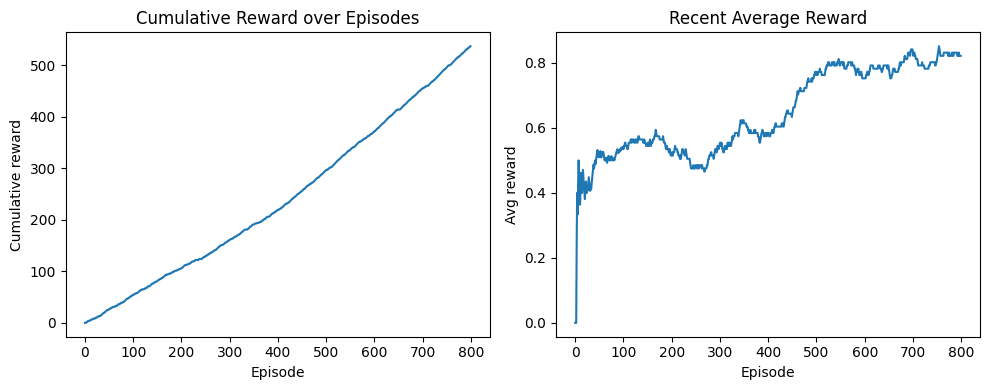

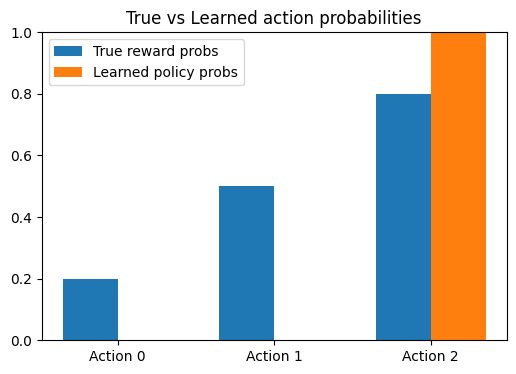

In [9]:
#results and plots
final_probs = policy_probs(params)
print("Ground-truth bandit probs:", bandit_probs)
print("Learned action probabilities:", np.round(final_probs, 3))

# cumulative reward plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.cumsum(rewards), label='Cumulative reward')
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.title('Cumulative Reward over Episodes')
plt.subplot(1,2,2)
plt.plot(avg_rewards, label='Recent avg reward (window 100)')
plt.xlabel('Episode')
plt.ylabel('Avg reward')
plt.title('Recent Average Reward')
plt.tight_layout()
plt.show()

# show learned vs true
plt.figure(figsize=(6,4))
x = np.arange(n_actions)
width = 0.35
plt.bar(x - width/2, bandit_probs, width, label='True reward probs')
plt.bar(x + width/2, final_probs, width, label='Learned policy probs')
plt.xticks(x, [f"Action {i}" for i in range(n_actions)])
plt.ylim(0,1)
plt.legend()
plt.title("True vs Learned action probabilities")
plt.show()
